✅ Total Audio Files Loaded: 245208

🔹 SNR_-5:
   - Airport: 10217 samples
   - Babble: 10217 samples
   - Resturant: 10217 samples
   - Station: 10217 samples

🔹 SNR_-3:
   - Airport: 10217 samples
   - Babble: 10217 samples
   - Resturant: 10217 samples
   - Station: 10217 samples

🔹 SNR_0:
   - Airport: 10217 samples
   - Babble: 10217 samples
   - Resturant: 10217 samples
   - Station: 10217 samples

🔹 SNR_3:
   - Airport: 10217 samples
   - Babble: 10217 samples
   - Resturant: 10217 samples
   - Station: 10217 samples

🔹 SNR_5:
   - Airport: 10217 samples
   - Babble: 10217 samples
   - Resturant: 10217 samples
   - Station: 10217 samples

🔹 SNR_10:
   - Airport: 10217 samples
   - Babble: 10217 samples
   - Resturant: 10217 samples
   - Station: 10217 samples

🔍 Dataset Distribution Table:
        Airport  Babble  Resturant  Station
SNR_-5    10217   10217      10217    10217
SNR_-3    10217   10217      10217    10217
SNR_0     10217   10217      10217    10217
SNR_3     10217  

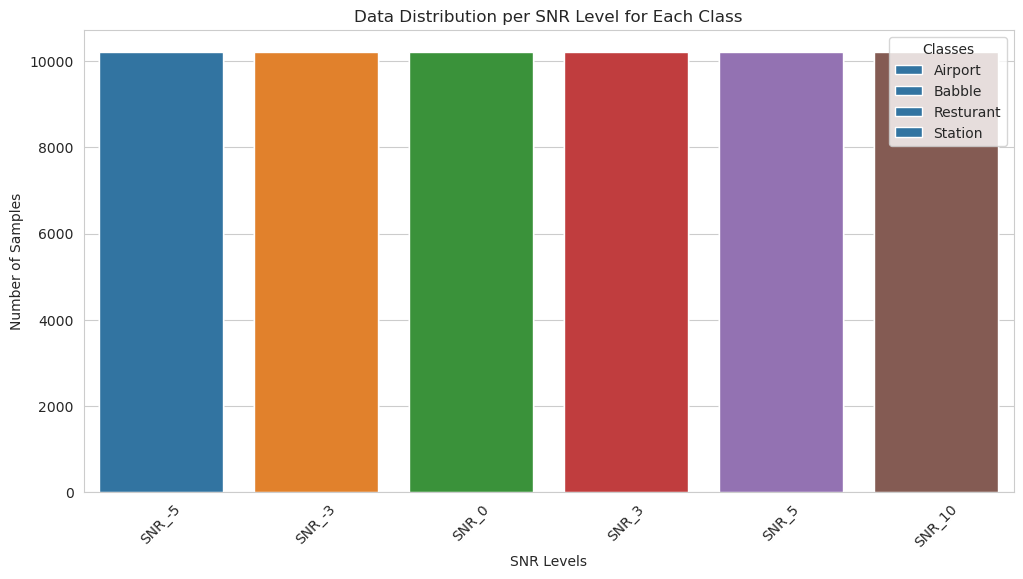

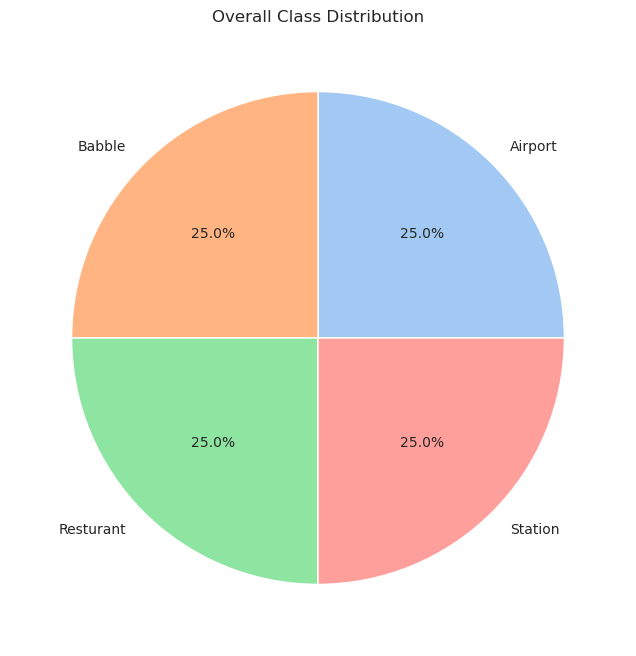

✅ Train: 176549, Val: 19617, Test: 49042


In [6]:
import torch
import torchaudio
import torchaudio.transforms as T
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# ✅ Step 1: Define Paths & Classes
DATASET_PATH = "/home/chetak/Speech_Mixing/Clean+Noise Speech/"
SNR_FOLDERS = ["SNR_-5", "SNR_-3", "SNR_0", "SNR_3", "SNR_5", "SNR_10"]
CLASS_MAP = {"Airport": 0, "Babble": 1, "Resturant": 2, "Station": 3}

# ✅ Step 2: Load Audio Files & Labels with SNR Count
def load_data(dataset_path, snr_folders):
    audio_files, labels = [], []
    snr_count = {snr: {class_name: 0 for class_name in CLASS_MAP.keys()} for snr in snr_folders}
    
    for snr in snr_folders:
        for class_name, label in CLASS_MAP.items():
            class_path = os.path.join(dataset_path, class_name, snr)
            files = glob.glob(os.path.join(class_path, "*.wav"))
            audio_files.extend(files)
            labels.extend([label] * len(files))
            snr_count[snr][class_name] = len(files)
    
    return audio_files, labels, snr_count

all_files, all_labels, snr_count = load_data(DATASET_PATH, SNR_FOLDERS)
print(f"✅ Total Audio Files Loaded: {len(all_files)}")

# ✅ Print Dataset Distribution
for snr, class_counts in snr_count.items():
    print(f"\n🔹 {snr}:")
    for class_name, count in class_counts.items():
        print(f"   - {class_name}: {count} samples")

# ✅ Convert to Pandas DataFrame for better visualization
df = pd.DataFrame.from_dict(snr_count, orient='index')
print("\n🔍 Dataset Distribution Table:")
print(df)

# ✅ Plot SNR Distribution
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
for class_name in CLASS_MAP.keys():
    sns.barplot(x=SNR_FOLDERS, y=[snr_count[snr][class_name] for snr in SNR_FOLDERS], label=class_name)
plt.xlabel("SNR Levels")
plt.ylabel("Number of Samples")
plt.title("Data Distribution per SNR Level for Each Class")
plt.legend(title="Classes")
plt.xticks(rotation=45)
plt.show()

# ✅ Pie Chart for Class Distribution
class_totals = {class_name: sum(snr_count[snr][class_name] for snr in SNR_FOLDERS) for class_name in CLASS_MAP.keys()}
plt.figure(figsize=(8, 8))
plt.pie(class_totals.values(), labels=class_totals.keys(), autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Overall Class Distribution")
plt.show()

# ✅ Step 3: Split Dataset (Train, Val, Test)
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.20, stratify=all_labels, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.10, stratify=train_labels, random_state=42)

print(f"✅ Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")


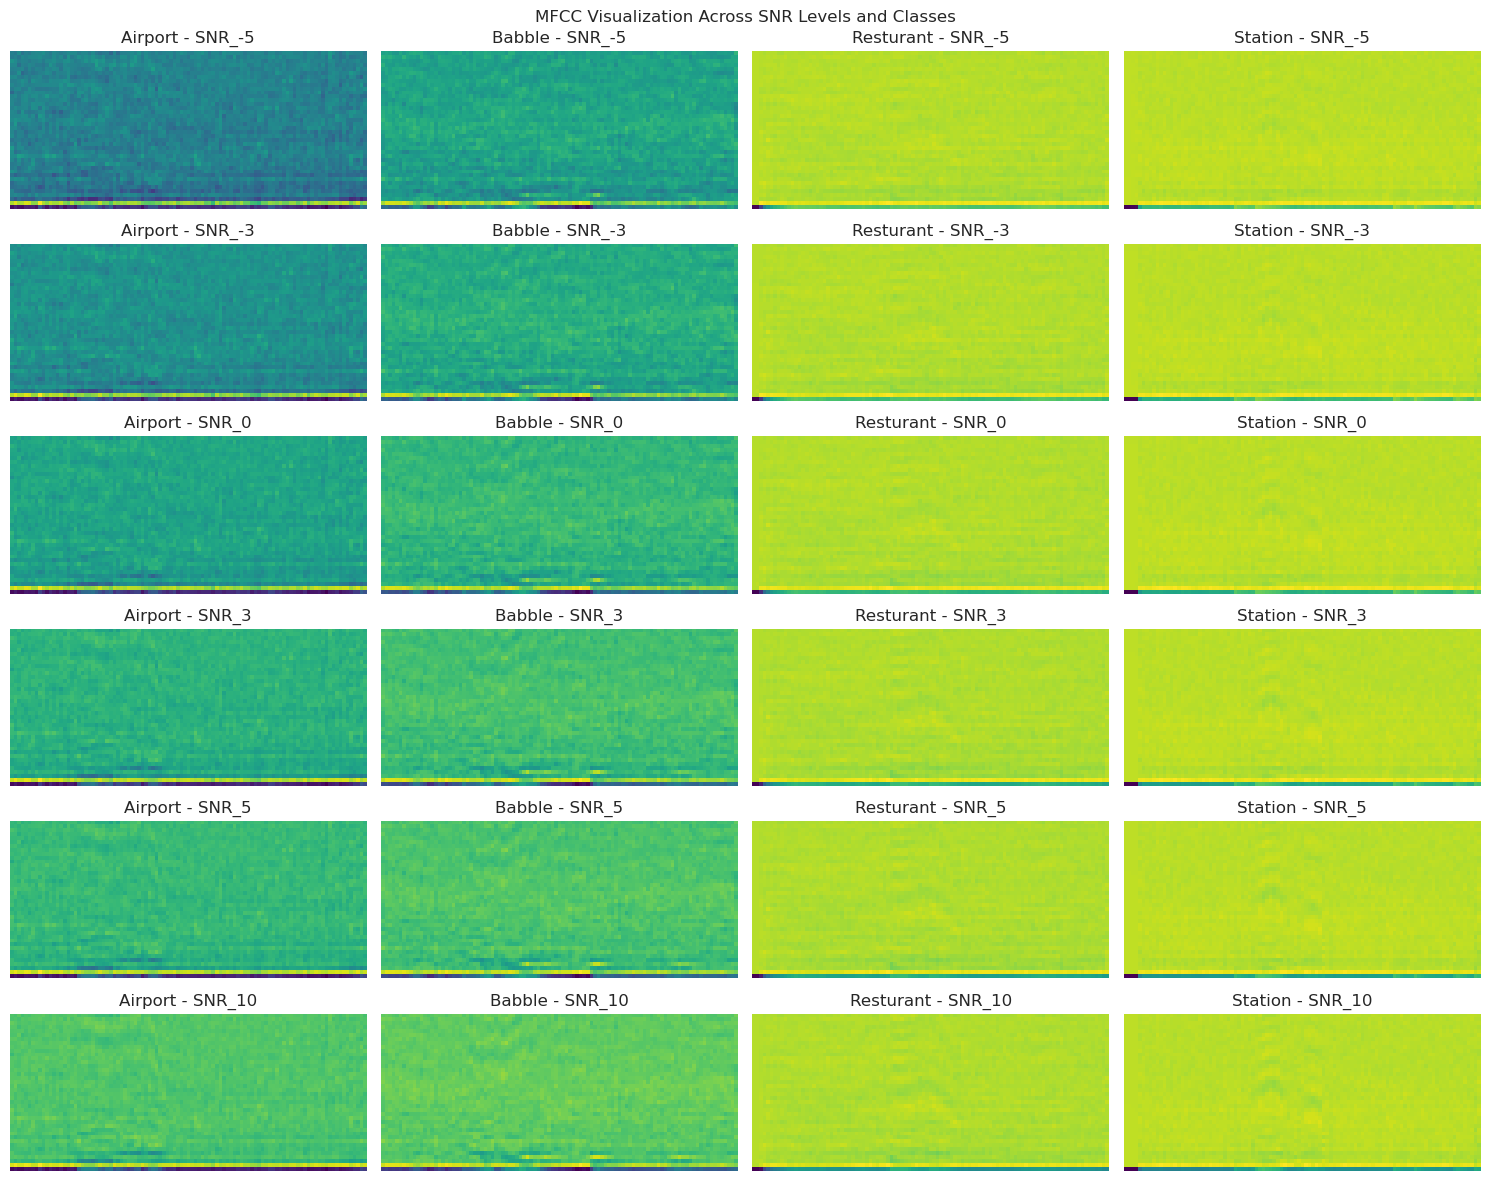

In [7]:
def plot_mfcc_examples(dataset_path, snr_folders, num_mfcc=40):
    fig, axes = plt.subplots(len(SNR_FOLDERS), len(CLASS_MAP), figsize=(15, 12))
    
    for i, snr in enumerate(snr_folders):
        for j, class_name in enumerate(CLASS_MAP.keys()):
            class_path = os.path.join(dataset_path, class_name, snr)
            files = glob.glob(os.path.join(class_path, "*.wav"))
            if not files:
                continue
            
            # Load a sample audio file
            waveform, sample_rate = torchaudio.load(files[0])
            mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=num_mfcc)
            mfcc = mfcc_transform(waveform)
            
            # Plot MFCC
            ax = axes[i, j]
            ax.imshow(mfcc[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
            ax.set_title(f"{class_name} - {snr}")
            ax.axis("off")
    
    plt.suptitle("MFCC Visualization Across SNR Levels and Classes")
    plt.tight_layout()
    plt.show()

plot_mfcc_examples(DATASET_PATH, SNR_FOLDERS)


/tmp/ipykernel_2682380/3718139844.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


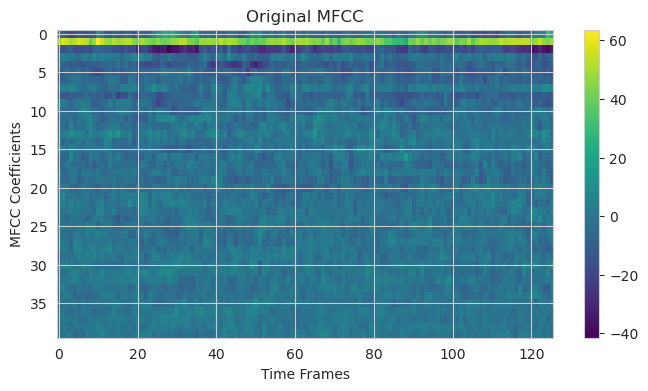

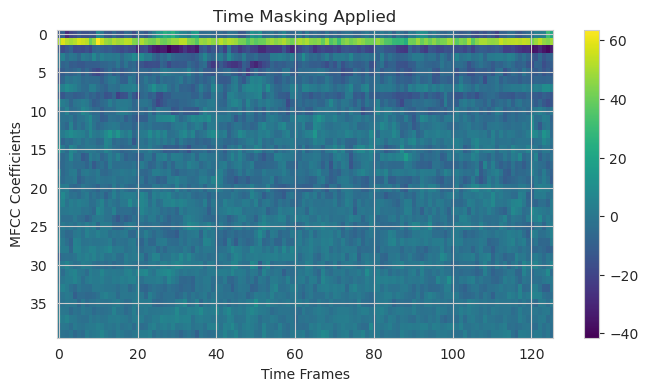

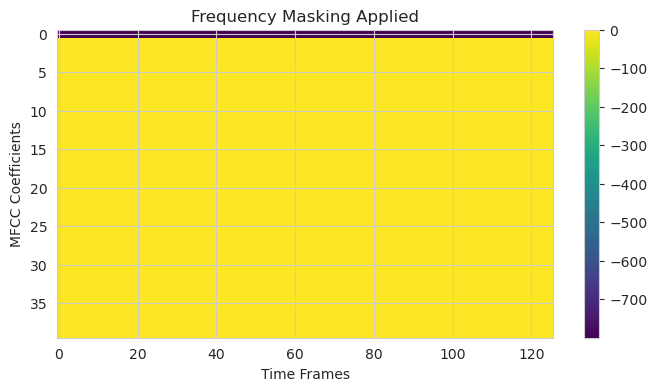

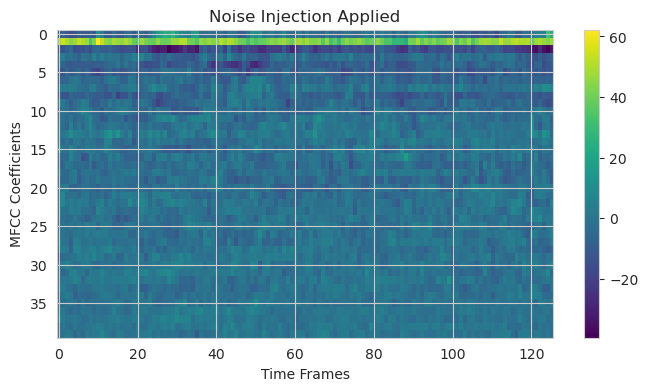

In [9]:
# ✅ Step 4: Data Augmentation & MFCC Visualization
def apply_augmentations(waveform, sample_rate):
    # Time Masking
    time_mask = T.TimeMasking(time_mask_param=80)
    masked_waveform = time_mask(waveform)
    
    # Frequency Masking
    freq_mask = T.FrequencyMasking(freq_mask_param=30)
    freq_masked_waveform = freq_mask(waveform)
    
    # Noise Injection
    noise = torch.randn_like(waveform) * 0.005
    noisy_waveform = waveform + noise
    
    return masked_waveform, freq_masked_waveform, noisy_waveform

# ✅ Visualizing MFCC before and after augmentation
def plot_mfcc(waveform, sample_rate, title):
    mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=40, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 64})
    mfcc = mfcc_transform(waveform)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(mfcc.squeeze().numpy(), cmap='viridis', aspect='auto')
    plt.title(title)
    plt.xlabel("Time Frames")
    plt.ylabel("MFCC Coefficients")
    plt.colorbar()
    plt.show()

# ✅ Select one sample for visualization
sample_file = all_files[0]
wav, sr = torchaudio.load(sample_file)
aug_time, aug_freq, aug_noise = apply_augmentations(wav, sr)

plot_mfcc(wav, sr, "Original MFCC")
plot_mfcc(aug_time, sr, "Time Masking Applied")
plot_mfcc(aug_freq, sr, "Frequency Masking Applied")
plot_mfcc(aug_noise, sr, "Noise Injection Applied")
